# Inital setup

In [8]:
import time

import torch 
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

import resnet as rnet

import matplotlib.pyplot as plt
import numpy as np
import math

cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
print(f"using device {device}")

path = "./"

filenameSuffix = "4"

using device cuda:0


### Help functions

In [21]:
def validateFunc(model, val_loader, batches):
    global valnum
    valnum = []
    with torch.no_grad():
        valacc = []

        model.eval()

        for i, (images, targets) in enumerate(val_loader):
            if i >= batches:
                break
            if cuda_available: 
                images = images.cuda()
                targets = targets.cuda()

            t = time.time()
            prediction = model.forward(images)

            valacc = valacc + [get_xent_acc(prediction, targets)]
            valnum = valnum + [len(targets)]

        model.train()

        return valacc

In [3]:
def make_oneh(labels):
    oneh_labels = np.zeros([labels.shape[0], 10])
    indexes = np.array([np.arange(0,labels.shape[0]), labels.numpy()])
    oneh_labels[tuple(indexes)] = 1.0
    return torch.tensor(oneh_labels).long()
def get_xent_acc(prediction, labels):
    prediction = prediction.cpu().data.numpy()
    labels = labels.cpu().data.numpy()
    predicted_labels = np.argmax(prediction,1)
    return sum((predicted_labels - labels) == 0)/predicted_labels.shape[0]
def xent_softmax(prediction):
    pred = np.exp(prediction.cpu().data.numpy())
    divide = np.repeat(pred.sum(1).reshape(pred.shape[0],1), pred.shape[1],1)
    pred = np.divide(pred,divide)
    return pred 

In [4]:
def trainFunc(model, lossfn, optimizer, data_loader, val_loader, min_lr, max_lr, n_epochs=1, validation_interval=10):
    start    = time.time()
    accuracy = [] 
    loss     = []
    valacc   = []
    lr       = []

    model.train()
    
    lastEpochs = math.floor(n_epochs/10)
    iterations = (n_epochs - lastEpochs) * len(data_loader)
    if iterations % 2 != 0:
        iterations -= len(data_loader)
        lastEpochs += 1
        
    iterations /= 2
    
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, min_lr, max_lr, 
                                                  step_size_up=iterations, step_size_down=iterations, 
                                                  base_momentum=0.95,
                                                  mode='triangular', cycle_momentum=False)
    
    print("starting training")
    
    updateStep = 0
    for epoch in range(n_epochs):
        data_iterator = iter(data_loader)
        
        # attempt at annealing
        if epoch == n_epochs - lastEpochs:
            iterations = lastEpochs * len(data_loader)
            optimizer = optim.SGD(model.parameters(),
                          lr=0.1,
                          momentum=0.95,
                          weight_decay=1e-4)
            scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, min_lr*0.1, min_lr, 
                                                  step_size_up=1, step_size_down=iterations, 
                                                  base_momentum=0.95,
                                                  mode='triangular', cycle_momentum=False)
            scheduler.step()
        
        for i, (images, labels) in enumerate(data_iterator):
            t = time.time()

            f"""if we use GPU, input- and target-tensors must be loaded on GPU as well."""
            if cuda_available: 
                images = images.cuda()
                labels = labels.cuda()

            prediction = model.forward(images)
            output     = lossfn(prediction, labels)

            accuracy = accuracy + [get_xent_acc(prediction, labels)]
            loss     = loss + [output]

            optimizer.zero_grad()
            output.backward() # calculates gradients 
            optimizer.step()  # updates weights
            scheduler.step()
            
            lr = lr + [optimizer.param_groups[-1]['lr']]

            if validation_interval > 0 and updateStep % validation_interval == 0:
                valacc = valacc + validateFunc(model, val_loader, 1)
            updateStep += 1

        print(f"""time passed after training {epoch} epochs is {time.time()-start} seconds""")
    return (accuracy, loss, valacc, lr)

def cuda(thing):
    if cuda_available:
        return thing.cuda()
    return thing

def range_test(net,opt,dataloader,lossfn,min_lr,max_lr,iterations,batchsize):
    scheduler = torch.optim.lr_scheduler.CyclicLR(opt, min_lr, max_lr, 
                                                  step_size_up=iterations, step_size_down=0, 
                                                  base_momentum=0,
                                                  mode='triangular', cycle_momentum=False)
    start    = time.time()
    time_int = 100
    
    accuracy  = []
    loss      = []
    interval  = 5
    i         = 0
    while i < iterations:
        datait = iter(dataloader)
        for n, (images, labels) in enumerate(datait):
            images, labels = cuda(images), cuda(labels)
            prediction = net.forward(images)
            output     = lossfn(prediction, labels)
            # Use accuracy on training-set
            if i % interval == 0:
                accuracy   = accuracy + [get_xent_acc(prediction, labels)]
                loss       = loss + [output]
            opt.zero_grad()   # clear gradients from previous time-step 
            output.backward() # calculates gradients 
            opt.step()        # updates weights
            scheduler.step()  # change learning-rate in range_optimizer
            if i % time_int == 0:
                print(f"time after {i} iterations: {time.time() - start} seconds")
                
            i += 1
            if i >= iterations:
                break
                
    print(f"time after {i} iterations: {time.time() - start} seconds")
            
    f"""make and save plot of accuracy"""
    x1, x2 = [np.linspace(min_lr, max_lr, num) for num in [len(accuracy), len(loss)]]
    plt.plot(x1, np.array(accuracy))
    momentum = opt.param_groups[-1]['momentum']
    weightdecay = opt.param_groups[-1]['weight_decay']
    save_file = path+f"/rangetest{filenameSuffix}/acc_bs{batchsize}_minlr{min_lr}_maxlr{max_lr}_iterations{iterations}_momentum{momentum}_weightdecy{weightdecay}.png"
    plt.savefig(save_file)
    plt.show()
    plt.clf()
    return accuracy, loss

### create loss function 
#### https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7

In [5]:
loss_xent = nn.CrossEntropyLoss()
loss_mse  = nn.MSELoss()

### play with forward and backwards pass

In [14]:
def getNet(batch_size, min_lr=None, max_lr=None):
    # Configure
    resnet = rnet.resnet56()
    optimizer = optim.SGD(resnet.parameters(),
                          lr=0.1,
                          momentum=0.95,
                          weight_decay=1e-4)
    rt_optimizer = optim.SGD(resnet.parameters(),
                          lr=0.1,
                          momentum=0,
                          weight_decay=0)

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])

    data_loader = torch.utils.data.DataLoader(
            torchvision.datasets.CIFAR10(path, train=True, transform=transforms.Compose([
                #transforms.RandomHorizontalFlip(),
                #transforms.RandomCrop(32, 4),
                transforms.ToTensor(),
                normalize,
            ]), download=True),
            batch_size=batch_size, shuffle=True,
            num_workers=0, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(path, train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=batch_size, shuffle=False,
        num_workers=0, pin_memory=True)
    
    cuda(resnet)
    
    return (resnet, optimizer, rt_optimizer, data_loader, val_loader)

In [5]:
params = [(128, 36, 0.04, 0.4),
         (256, 47, 0.06, 0.6),
         (512, 50, 0.08, 0.8),
         (1024, 52, 0.1, 1)]


In [16]:
for i, (batch_size, epochs, min_lr, max_lr) in enumerate(params):
    break
    (model, optimizer, rt_optimizer, data_loader, val_loader) = getNet(batch_size, min_lr, max_lr)
    (acc, loss) = range_test(model, rt_optimizer, data_loader, loss_xent, 0, 2, 10000/2**i, batch_size)
    np.save(f"rt{filenameSuffix}_acc{i}", acc)
    np.save(f"rt{filenameSuffix}_loss{i}", loss)
    torch.save(model.state_dict(), f"rt{filenameSuffix}_model{i}")
    
for i, (batch_size, epochs, min_lr, max_lr) in enumerate(params):
    (model, optimizer, rt_optimizer, data_loader, val_loader) = getNet(batch_size, min_lr, max_lr)
    (acc, loss, valacc, lr) = trainFunc(model, nn.CrossEntropyLoss(), optimizer, data_loader, val_loader, min_lr, max_lr, epochs, validation_interval=50)
    np.save(f"tr{filenameSuffix}_acc{i}", acc)
    np.save(f"tr{filenameSuffix}_loss{i}", loss)
    np.save(f"tr{filenameSuffix}_valacc{i}", valacc)
    np.save(f"tr{filenameSuffix}_lr{i}", lr)
    torch.save(model.state_dict(), f"tr{filenameSuffix}_model{i}")
    

Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Sequential
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
LambdaLayer
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
Ba

[0.8762, 0.87, 0.8688, 0.8461]


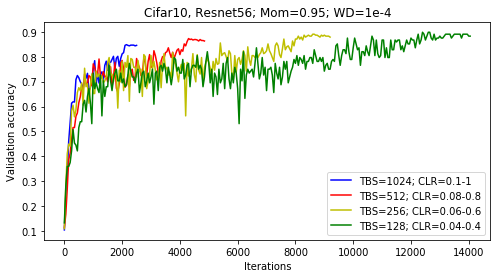

In [36]:
for i, (batch_size, epochs, min_lr, max_lr) in enumerate(params):
    break
    (model, optimizer, rt_optimizer, data_loader, val_loader) = getNet(batch_size, min_lr, max_lr)
    model.load_state_dict(torch.load(f"tr{filenameSuffix}_model{i}"))
    val = np.array(validateFunc(model, val_loader, 1000000))
    val = val * np.array(valnum)
    tot = np.sum(valnum)
    valarr = valarr + [np.sum(val)/tot]

print(valarr)

plt.figure(figsize=(8, 4))

legends = []
plt.clf()
colors = ['b', 'r', 'y', 'g']
for i, (batch_size, epochs, min_lr, max_lr) in enumerate(params[::-1]):
    acc = np.load(f"tr{filenameSuffix}_valacc{3-i}.npy")
    plt.plot(np.arange(len(acc)) * 50, acc, colors[i])
    legends += [f"TBS={batch_size}; CLR={min_lr}-{max_lr}"]

plt.legend(legends)
plt.title("Cifar10, Resnet56; Mom=0.95; WD=1e-4")
plt.savefig("batchsize_fig.png")
plt.xlabel("Iterations")
plt.ylabel("Validation accuracy")
plt.show()
    

In [ ]:
(accuracy, loss, validationacc) = trainFunc(resnet, nn.CrossEntropyLoss(), optimizer, n_epochs=40, validation_interval=0)

In [ ]:
res.append((accuracy, loss, validationacc))

In [ ]:
x = np.arange(0,len(accuracy))
plt.plot(x,np.array(accuracy),np.array(loss))
x = np.arange(0,len(validationacc))
plt.plot(x, np.array(validationacc))

In [ ]:
t = time.time()
valacc = validateFunc(resnet, 100)
print(f"{time.time()-t:2.4f}\nacc {np.mean(valacc):.7f}")

#### DenseNet

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
if cuda_available:
    images = images.cpu()
imshow(torchvision.utils.make_grid(images))

In [ ]:
densenet = models.densenet161()

In [ ]:
for i, (batch_size, epochs, min_lr, max_lr, iterations) in enumerate(params):
    acc = np.load(f"tr{filenameSuffix}_acc{i}.npy")
    loss = np.load(f"tr{filenameSuffix}_loss{i}.npy")
    valacc = np.load(f"tr{filenameSuffix}_valacc{i}.npy")
    
    #x1, x2 = [np.linspace(min_lr, max_lr, num) for num in [len(accuracy), len(loss)]]
    x = range(len(valacc))
    plt.plot(x, valacc)
    save_file = path+f"plot{filenameSuffix}_valacc_{batch_size}.png"
    plt.savefig(save_file)
    plt.show()
    plt.clf()
    print(loss[-1], acc[-1], valacc[-1])
    print(np.min(loss), np.max(acc), np.max(valacc))
    